100%|██████████| 200/200 [02:16<00:00,  1.47it/s]


MSE: 0.9646
MAE: 0.6288
MAPE: 554.9057%
RMSE: 0.9821
R-squared: 0.0420


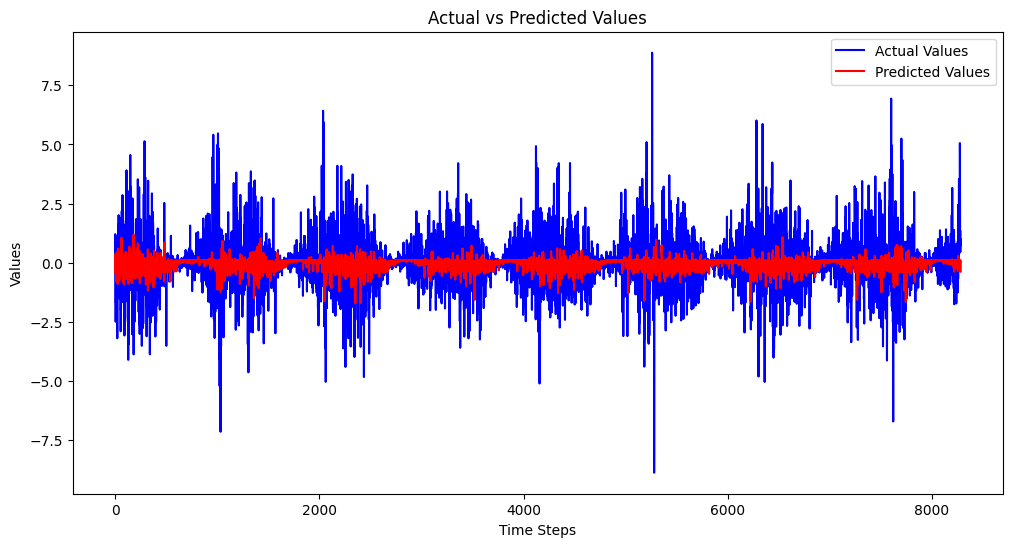

In [4]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvLSTM

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
loader = ChickenpoxDatasetLoader()
dataset = loader.get_dataset()
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

# Define the Recurrent GCN model
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvLSTM(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

# Initialize the model and optimizer
model = RecurrentGCN(node_features=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training phase
model.train()
for epoch in tqdm(range(200)):
    cost = 0
    h, c = None, None  # Initialize hidden and cell states
    for time, snapshot in enumerate(train_dataset):
        # Forward pass
        y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
        # Detach hidden and cell states to avoid retaining the graph
        h, c = h.detach(), c.detach()
        # Compute loss (MSE)
        loss = torch.mean((y_hat - snapshot.y) ** 2)
        cost += loss
        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    cost /= (time + 1)

# Evaluation phase
model.eval()
predictions = []
actuals = []
h, c = None, None  # Re-initialize hidden and cell states for evaluation
for time, snapshot in enumerate(test_dataset):
    y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
    predictions.append(y_hat.detach().cpu().numpy())
    actuals.append(snapshot.y.detach().cpu().numpy())

# Convert lists to numpy arrays
predictions = np.array(predictions).squeeze()
actuals = np.array(actuals).squeeze()

# Calculate evaluation metrics
mse = np.mean((predictions - actuals) ** 2)
mae = np.mean(np.abs(predictions - actuals))
mape = np.mean(np.abs((predictions - actuals) / actuals)) * 100
rmse = np.sqrt(mse)
ss_total = np.sum((actuals - np.mean(actuals)) ** 2)
ss_residual = np.sum((actuals - predictions) ** 2)
r_squared = 1 - (ss_residual / ss_total)

# Print evaluation metrics
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r_squared:.4f}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actuals.flatten(), label='Actual Values', color='blue')
plt.plot(predictions.flatten(), label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend()
plt.show()
